## Get the data

In [1]:
import numpy as np
import pandas as pd


# TODO: install from T4 package
# local metadata filepath
# metadata_filepath = '../../comet/data/training/X_meta.csv'
# remote metadata filepath
metadata_filepath = '../../X_meta.csv'

# local images filepath
# images_cropped = '../../comet/data/images_cropped/'
# remote images filepath
images_cropped = '../../images_cropped/'


X_meta = (pd.read_csv(metadata_filepath)
          .groupby('LabelName')
          .head(1000)
          .groupby('LabelName')
          .filter(lambda gdf: len(gdf) >= 1000)
          .reset_index(drop=True))

## Define the model

In [2]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

batch_size = 64

train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1/255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)
test_datagen = ImageDataGenerator(
    rescale=1/255
)
train_generator = train_datagen.flow_from_dataframe(
    X_meta,
    directory=images_cropped,
    x_col='CroppedImageURL',
    y_col='LabelName',
    target_size=(48, 48),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)
validation_generator = train_datagen.flow_from_dataframe(
    X_meta,
    directory=images_cropped,
    x_col='CroppedImageURL',
    y_col='LabelName',    
    target_size=(48, 48),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)


# define the model
import keras
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout
from keras.optimizers import SGD

def bottleneck():
    prior = keras.applications.VGG16(
        include_top=False, 
        weights='imagenet',
        input_shape=(48, 48, 3)
    )
    model = Sequential()
    model.add(prior)
    model.add(Flatten())
    model.add(Dense(256, activation='relu', name='Dense_Intermediate'))
    model.add(Dropout(0.2, name='Dropout_Regularization'))
    model.add(Dense(8, activation='sigmoid', name='Output'))
    model.layers[0].trainable = False
    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

Using TensorFlow backend.


Found 6400 images belonging to 8 classes.
Found 1600 images belonging to 8 classes.


## Define the model wrapper

In [3]:
# define the KerasClassifier wrapper wrapper
import numpy as np
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.base import BaseEstimator
class KerasBatchClassifier(KerasClassifier, BaseEstimator):
    def __init__(self, model, **kwargs):
        super().__init__(model)
        self.fit_kwargs = kwargs
        self._estimator_type = 'classifier'

    def fit(self, *args, **kwargs):
        # taken from keras.wrappers.scikit_learn.KerasClassifier.fit
        self.model = self.build_fn(**self.filter_sk_params(self.build_fn))
        
        self.classes_ = np.array(range(len(self.fit_kwargs['train_generator'].class_indices)))
        self.__history = self.model.fit_generator(
            self.fit_kwargs.pop('train_generator'), 
            **self.fit_kwargs
        )

clf = KerasBatchClassifier(
    bottleneck,
    train_generator=train_generator,
    epochs=10,
    steps_per_epoch=len(train_generator.filenames) // batch_size,
    validation_data=validation_generator,
    validation_steps=len(train_generator.filenames) // batch_size,
    callbacks=[EarlyStopping(patience=1, restore_best_weights=True)]
)

## Fit the model

In [4]:
clf.fit()

58892288/58889256 [==============================] - 1s 0us/step
Epoch 1/10
100/100 [==============================] - 213s 2s/step - loss: 1.7461 - acc: 0.3581 - val_loss: 1.8285 - val_acc: 0.3469
Epoch 2/10
100/100 [==============================] - 87s 871ms/step - loss: 1.5562 - acc: 0.4397 - val_loss: 1.7656 - val_acc: 0.3345
Epoch 3/10
100/100 [==============================] - 89s 893ms/step - loss: 1.4735 - acc: 0.4630 - val_loss: 1.8667 - val_acc: 0.3123


## The four built-in metrics in keras

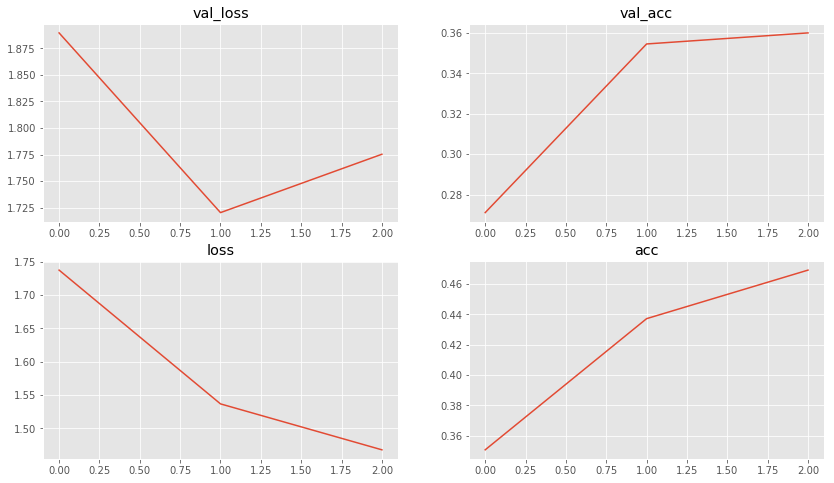

In [5]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

fig, axarr = plt.subplots(2, 2, figsize=(14, 8))
for i, metric in enumerate(clf.model.history.history):
    res = clf.model.history.history[metric]
    j, k = i // 2, i % 2
    axarr[j][k].plot(range(len(res)), res)
    axarr[j][k].set_title(metric)

## Visualization batch generator 

In [31]:
visualization_generator = train_datagen.flow_from_dataframe(
    X_meta,
    directory=images_cropped,
    x_col='CroppedImageURL',
    y_col='LabelName',    
    target_size=(48, 48),
    batch_size=8000,
    class_mode='categorical'
)

Found 8000 images belonging to 8 classes.


## ClassPredictionError

8000/8000 [==============================] - 7s 815us/step


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


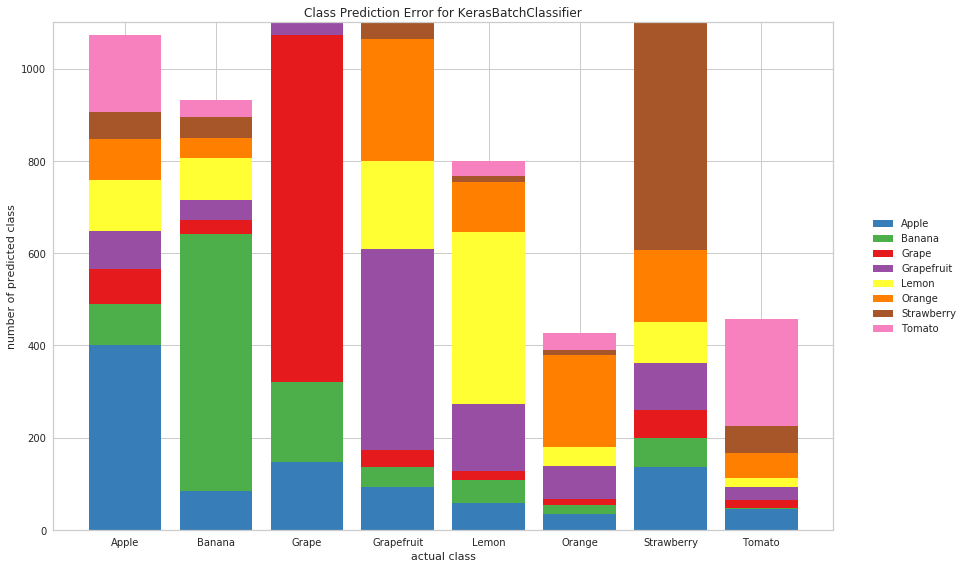

In [32]:
# bigger for the article

%matplotlib inline
import matplotlib.pyplot as plt
from yellowbrick.classifier import ClassPredictionError

fig, ax = plt.subplots(figsize=(16, 8))

X, y = visualization_generator.next()
y = np.argmax(y, axis=1)

from yellowbrick.style import set_palette
set_palette('Set1')
visualizer = ClassPredictionError(
    clf, ax=ax, classes=list(visualization_generator.class_indices.keys())
)
visualizer.score(X, y)
visualizer.poof()

In [39]:
# from yellowbrick.classifier import ClassPredictionError

# X, y = visualization_generator.next()
# y = np.argmax(y, axis=1)

# visualizer = ClassPredictionError(clf)
# visualizer.score(X, y)
# visualizer.poof()

## ConfusionMatrix

In [37]:
# from yellowbrick.classifier import ConfusionMatrix

# X, y = visualization_generator.next()
# y = np.argmax(y, axis=1)

# visualizer = ConfusionMatrix(clf)
# visualizer.score(X, y)
# visualizer.poof()

8000/8000 [==============================] - 7s 816us/step


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


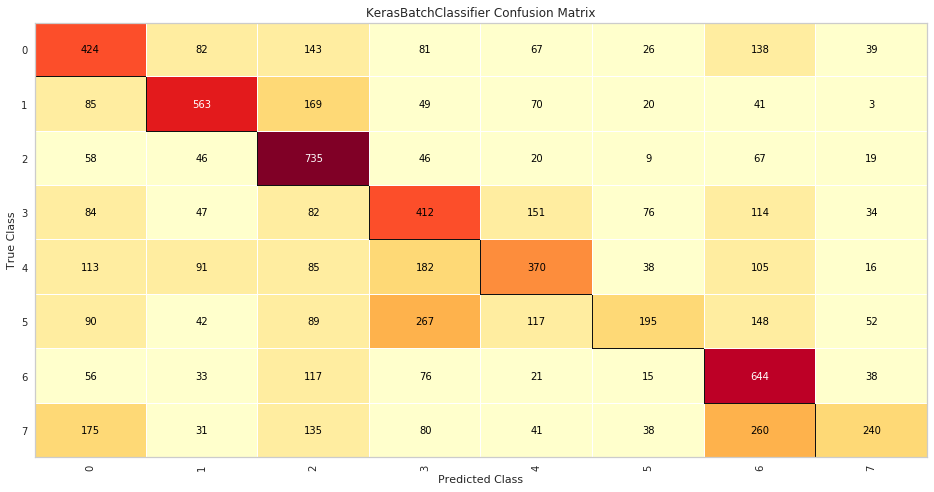

In [36]:
# bigger for the article

from yellowbrick.classifier import ConfusionMatrix

fig, ax = plt.subplots(figsize=(16, 8))

X, y = visualization_generator.next()
y = np.argmax(y, axis=1)

from yellowbrick.style import set_palette
set_palette('yellowbrick')
visualizer = ConfusionMatrix(clf, ax=ax)
visualizer.score(X, y)
visualizer.poof()

## ClassificationReport

8000/8000 [==============================] - 7s 819us/step


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


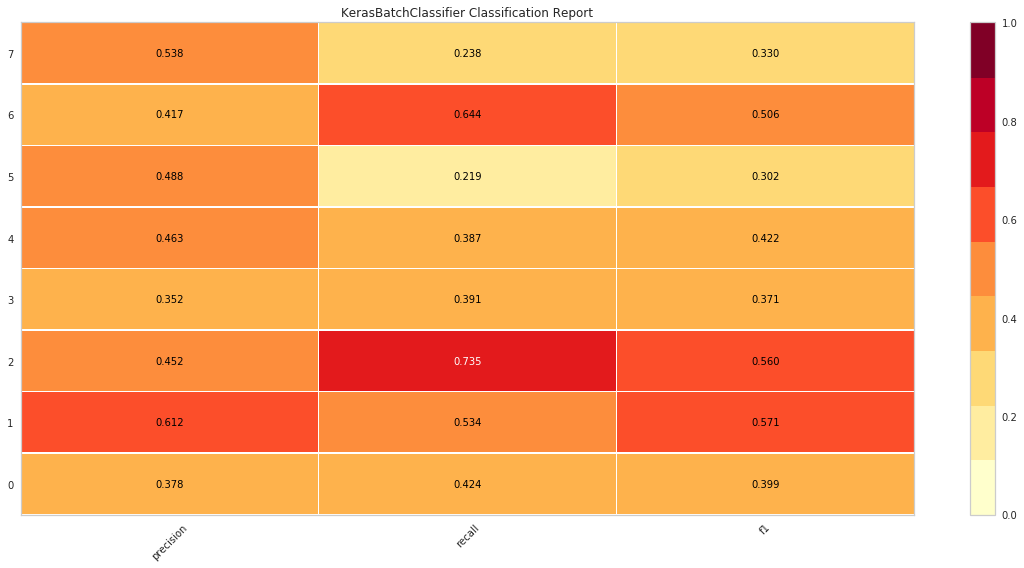

In [38]:
# bigger for the article

import numpy as np
from yellowbrick.classifier import ClassificationReport

fig, ax = plt.subplots(figsize=(16, 8))

X, y = visualization_generator.next()
y = np.argmax(y, axis=1)

visualizer = ClassificationReport(clf)
visualizer.score(X, y)
visualizer.poof()

## DiscriminationThreshold

**Note**: this plot type only works on binary classifiers. So we will first have to define a binary classifier on a subset of our data.

**Note**: this plot type requires a clone operation internally, which is not supported. =(

In [40]:
# from yellowbrick.classifier import DiscriminationThreshold

# binary_train_generator = train_datagen.flow_from_dataframe(
#     X_meta.query('LabelName == "Orange" or LabelName == "Strawberry"'),
#     directory=images_cropped,
#     x_col='CroppedImageURL',
#     y_col='LabelName',
#     target_size=(48, 48),
#     batch_size=batch_size,
#     class_mode='categorical',
#     subset='training'
# )
# binary_validation_generator = train_datagen.flow_from_dataframe(
#     X_meta.query('LabelName == "Orange" or LabelName == "Strawberry"'),
#     directory=images_cropped,
#     x_col='CroppedImageURL',
#     y_col='LabelName',    
#     target_size=(48, 48),
#     batch_size=batch_size,
#     class_mode='categorical',
#     subset='validation'
# )
# binary_visualization_generator = train_datagen.flow_from_dataframe(
#     X_meta.query('LabelName == "Orange" or LabelName == "Strawberry"'),
#     directory=images_cropped,
#     x_col='CroppedImageURL',
#     y_col='LabelName',    
#     target_size=(48, 48),
#     batch_size=1000,
#     class_mode='categorical',
# )

In [41]:
# define the model
# import keras
# from keras.models import Sequential
# from keras.layers import Flatten, Dense, Dropout
# from keras.optimizers import SGD

# def binary_bottleneck():
#     prior = keras.applications.VGG16(
#         include_top=False, 
#         weights='imagenet',
#         input_shape=(48, 48, 3)
#     )
#     model = Sequential()
#     model.add(prior)
#     model.add(Flatten())
#     model.add(Dense(256, activation='relu', name='Dense_Intermediate'))
#     model.add(Dropout(0.2, name='Dropout_Regularization'))
#     model.add(Dense(2, activation='sigmoid', name='Output'))
#     model.layers[0].trainable = False
#     model.compile(optimizer='rmsprop',
#                   loss='categorical_crossentropy',
#                   metrics=['accuracy'])
#     return model

In [42]:
# binary_clf = KerasBatchClassifier(
#     binary_bottleneck,
#     train_generator=binary_train_generator,
#     epochs=1,
#     steps_per_epoch=len(binary_train_generator.filenames) // batch_size,
#     validation_data=binary_validation_generator,
#     validation_steps=len(binary_train_generator.filenames) // batch_size,
#     callbacks=[EarlyStopping(patience=1, restore_best_weights=True)]
# )

In [43]:
# binary_clf.fit()

In [44]:
# from yellowbrick.classifier import DiscriminationThreshold

# X, y = binary_visualization_generator.next()
# y = np.argmax(y, axis=1)

# # sort
# s = np.argsort(y)
# y = y[s]
# X = X[s]

# visualizer = DiscriminationThreshold(binary_clf)
# visualizer.fit(X, y)
# visualizer.poof()